In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd
from glob import glob
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import math

'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

## Load Dataset

In [2]:
mask = glob('/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/*/*_mask*')
train = []

for i in mask:
    train.append(i.replace('_mask',''))
    
print (len(train), len(mask))

3929 3929


## Plot some samples

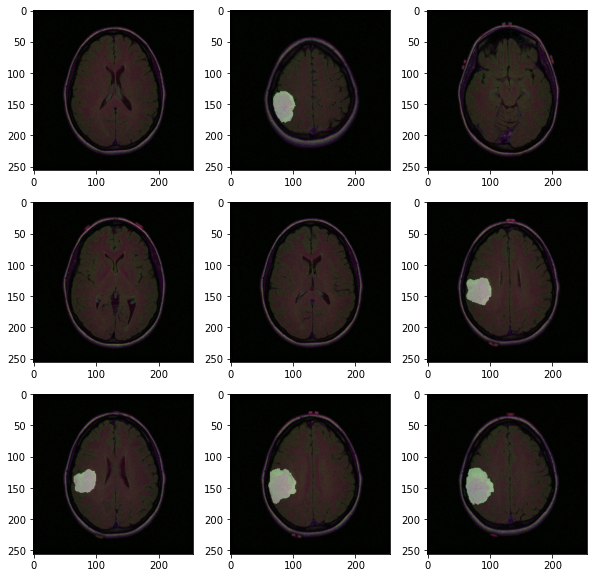

In [3]:
#Lets plot some samples
rows, cols = 3, 3

fig = plt.figure(figsize=(10,10))

for i in range(1, rows*cols + 1):
    fig.add_subplot(rows, cols, i)
    img=cv2.imread(train[i])
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    mask_img=cv2.imread(mask[i])
    
    plt.imshow(img)
    plt.imshow(mask_img,alpha=0.4)
plt.show()

## Create data frame and split data on train set and validation set

In [4]:
from sklearn.model_selection import train_test_split

df = pd.DataFrame(data={"filename": train, 'mask' : mask})
df_train, df_test = train_test_split(df, test_size = 0.2)
df_train, df_val = train_test_split(df_train, test_size = 0.1)

print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2828, 2)
(315, 2)
(786, 2)


## Data genertator, data augmentation and adjust data

From: https://github.com/zhixuhao/unet

In [5]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

## Unet

In [8]:
from model import UNet

#parameters
input_shape = (256, 256, 3)
classes = 1
img_size = 256
filters = [64, 128, 256, 512, 1024]

unet = UNet(input_shape, classes, img_size, filters, padding='same')


contract 64.0
64.0
expand_64.0 64.0
expand_128.0 128.0
expand_256.0_256.0
expand_512.0_512.0


In [9]:
unet.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
contracting_path_1_a (Conv2D)   (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           contracting_path_1_a[0][0]       
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         activation[0][0]                 
______________________________________________________________________________________________

## Loss Metrics

In [10]:
# Dice Loss
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
    denominator = tf.reduce_sum(y_true + y_pred, axis=-1)

    return 1 - (numerator + 1) / (denominator + 1)

## Training..

In [11]:
num_epochs = 100
batch_size = 32

train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train, batch_size,
                            train_generator_args,
                            target_size=(256, 256))
    
val_gen = train_generator(df_val, batch_size,
                          dict(),
                          target_size=(256, 256))

In [12]:

'''
#opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

#callbacks = [ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)]

results = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=len(df_val) / BATCH_SIZE)
'''

'\n#opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)\nmodel.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])\n\n#callbacks = [ModelCheckpoint(\'unet_brain_mri_seg.hdf5\', verbose=1, save_best_only=True)]\n\nresults = model.fit(train_gen,\n                    steps_per_epoch=len(df_train) / BATCH_SIZE, \n                    epochs=EPOCHS, \n                    callbacks=callbacks,\n                    validation_data = test_gener,\n                    validation_steps=len(df_val) / BATCH_SIZE)\n'

In [13]:
# Define step decay function
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses)))
        print('lr:', step_decay(len(self.losses)))

def step_decay(epoch):
    initial_lrate = 1e-4
    drop = 0.3
    epochs_drop = 40.0
    lrate = initial_lrate * math.pow(drop, math.floor((epoch)/epochs_drop))
    return lrate

# Callbacks
loss_history = LossHistory()
lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)
#earlystopper = EarlyStopping(patience=15, verbose=1)
checkpointer = ModelCheckpoint('model_unet_checkpoint.h5', verbose=1, save_best_only=True)
callbacks_list = [loss_history, lrate, checkpointer]

In [14]:
#lrate = 1e-3
#decay_rate = lrate / num_epochs

optimizer = Adam(lr=0.0)
unet.compile(optimizer=optimizer, loss=dice_loss, metrics=["binary_accuracy"])

In [15]:
print ('Training...')
results = unet.fit(train_gen,
                    steps_per_epoch = len(df_train) / batch_size, 
                    epochs = num_epochs, 
                    callbacks = callbacks_list,
                    validation_data = val_gen,
                    validation_steps = len(df_val) / batch_size)

Training...
Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/100
89/88 [==============================] - ETA: 0s - loss: 0.1699 - binary_accuracy: 0.7416Found 315 validated image filenames.
Found 315 validated image filenames.
lr: 0.0001

Epoch 00001: val_loss improved from inf to 0.08213, saving model to model_unet_checkpoint.h5
89/88 [==============================] - 110s 1s/step - loss: 0.1699 - binary_accuracy: 0.7416 - val_loss: 0.0821 - val_binary_accuracy: 0.9885 - lr: 1.0000e-04
Epoch 2/100
89/88 [==============================] - ETA: 0s - loss: 0.1091 - binary_accuracy: 0.8460lr: 0.0001

Epoch 00002: val_loss improved from 0.08213 to 0.01430, saving model to model_unet_checkpoint.h5
89/88 [==============================] - 94s 1s/step - loss: 0.1091 - binary_accuracy: 0.8460 - val_loss: 0.0143 - val_binary_accuracy: 0.9898 - lr: 1.0000e-04
Epoch 3/100
89/88 [==============================] - ETA: 0s - loss: 0.0898 - binary_accuracy: 0.8778

Epoch 25/100
89/88 [==============================] - ETA: 0s - loss: 0.0099 - binary_accuracy: 0.9899lr: 0.0001

Epoch 00025: val_loss did not improve from 0.00376
89/88 [==============================] - 87s 978ms/step - loss: 0.0099 - binary_accuracy: 0.9899 - val_loss: 0.0048 - val_binary_accuracy: 0.9912 - lr: 1.0000e-04
Epoch 26/100
89/88 [==============================] - ETA: 0s - loss: 0.0087 - binary_accuracy: 0.9915lr: 0.0001

Epoch 00026: val_loss improved from 0.00376 to 0.00354, saving model to model_unet_checkpoint.h5
89/88 [==============================] - 88s 988ms/step - loss: 0.0087 - binary_accuracy: 0.9915 - val_loss: 0.0035 - val_binary_accuracy: 0.9937 - lr: 1.0000e-04
Epoch 27/100
89/88 [==============================] - ETA: 0s - loss: 0.0081 - binary_accuracy: 0.9920lr: 0.0001

Epoch 00027: val_loss did not improve from 0.00354
89/88 [==============================] - 87s 980ms/step - loss: 0.0081 - binary_accuracy: 0.9920 - val_loss: 0.0076 - val_binary_accu

Epoch 50/100
89/88 [==============================] - ETA: 0s - loss: 0.0101 - binary_accuracy: 0.9835lr: 3e-05

Epoch 00050: val_loss did not improve from 0.00217
89/88 [==============================] - 90s 1s/step - loss: 0.0101 - binary_accuracy: 0.9835 - val_loss: 0.0042 - val_binary_accuracy: 0.9918 - lr: 3.0000e-05
Epoch 51/100
89/88 [==============================] - ETA: 0s - loss: 0.0032 - binary_accuracy: 0.9956lr: 3e-05

Epoch 00051: val_loss did not improve from 0.00217
89/88 [==============================] - 89s 996ms/step - loss: 0.0032 - binary_accuracy: 0.9956 - val_loss: 0.0025 - val_binary_accuracy: 0.9963 - lr: 3.0000e-05
Epoch 52/100
89/88 [==============================] - ETA: 0s - loss: 0.0026 - binary_accuracy: 0.9965lr: 3e-05

Epoch 00052: val_loss did not improve from 0.00217
89/88 [==============================] - 88s 984ms/step - loss: 0.0026 - binary_accuracy: 0.9965 - val_loss: 0.0025 - val_binary_accuracy: 0.9966 - lr: 3.0000e-05
Epoch 53/100
89/88 [==

Epoch 75/100
89/88 [==============================] - ETA: 0s - loss: 0.0017 - binary_accuracy: 0.9974lr: 3e-05

Epoch 00075: val_loss improved from 0.00165 to 0.00149, saving model to model_unet_checkpoint.h5
89/88 [==============================] - 87s 982ms/step - loss: 0.0017 - binary_accuracy: 0.9974 - val_loss: 0.0015 - val_binary_accuracy: 0.9975 - lr: 3.0000e-05
Epoch 76/100
89/88 [==============================] - ETA: 0s - loss: 0.0017 - binary_accuracy: 0.9974lr: 3e-05

Epoch 00076: val_loss did not improve from 0.00149
89/88 [==============================] - 86s 970ms/step - loss: 0.0017 - binary_accuracy: 0.9974 - val_loss: 0.0018 - val_binary_accuracy: 0.9970 - lr: 3.0000e-05
Epoch 77/100
89/88 [==============================] - ETA: 0s - loss: 0.0017 - binary_accuracy: 0.9974lr: 3e-05

Epoch 00077: val_loss did not improve from 0.00149
89/88 [==============================] - 88s 991ms/step - loss: 0.0017 - binary_accuracy: 0.9974 - val_loss: 0.0016 - val_binary_accurac

Epoch 100/100
89/88 [==============================] - ETA: 0s - loss: 0.0015 - binary_accuracy: 0.9974lr: 9e-06

Epoch 00100: val_loss did not improve from 0.00131
89/88 [==============================] - 92s 1s/step - loss: 0.0015 - binary_accuracy: 0.9974 - val_loss: 0.0014 - val_binary_accuracy: 0.9975 - lr: 9.0000e-06


## Train and Validation Loss

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy', 'lr'])


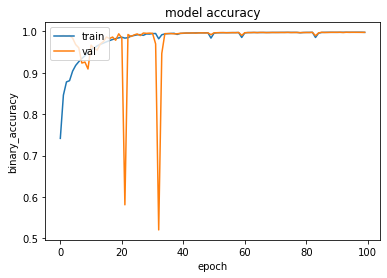

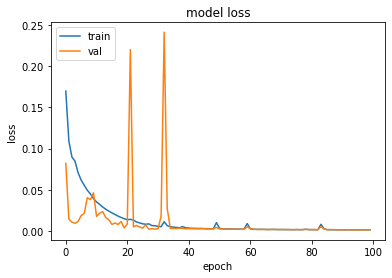

In [16]:
# list all data in history
print(results.history.keys())

# summarize history for accuracy
plt.plot(results.history['binary_accuracy'])
plt.plot(results.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Result

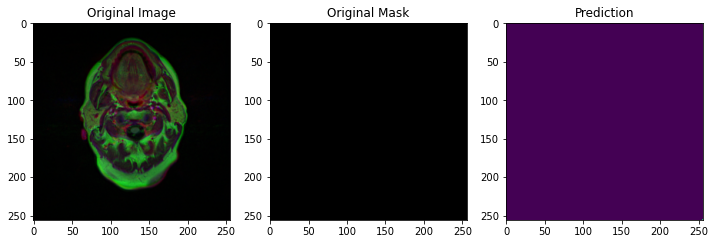

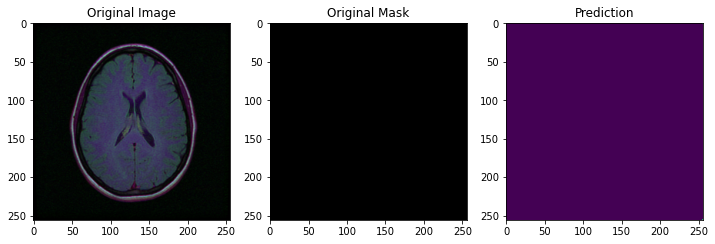

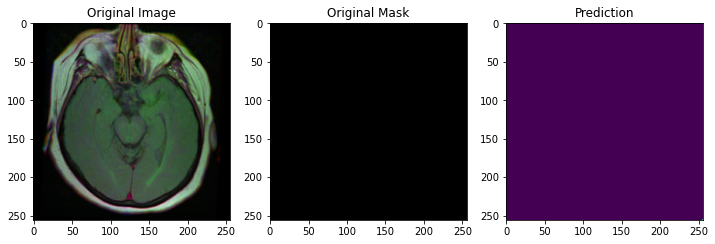

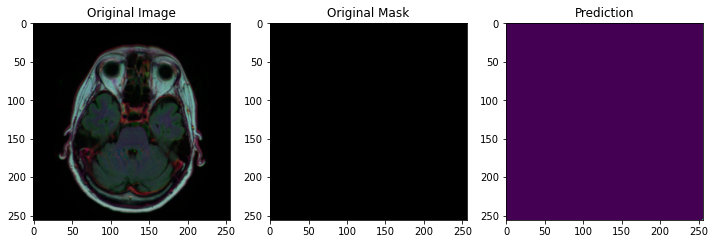

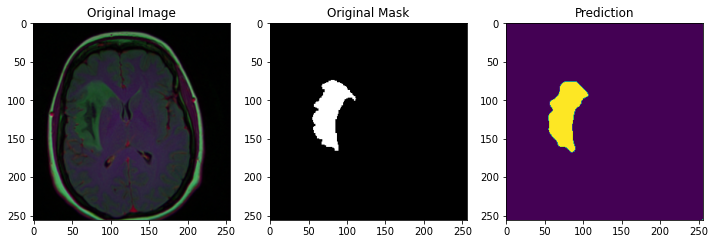

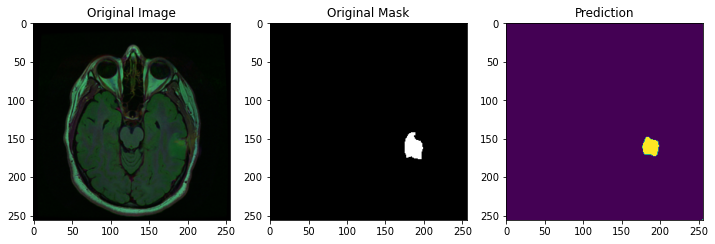

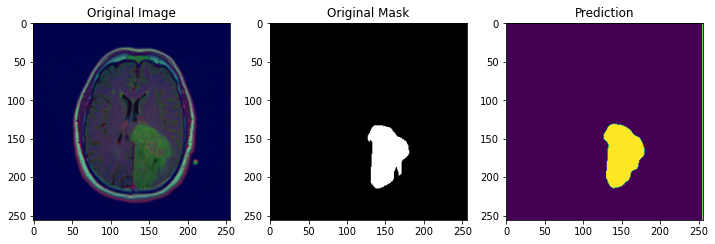

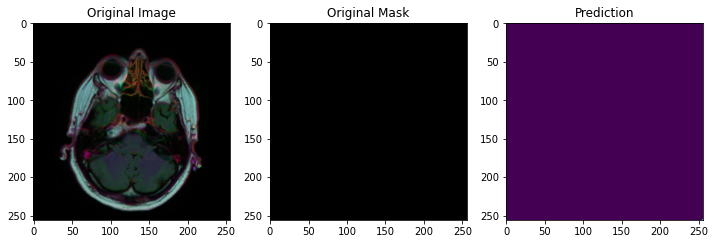

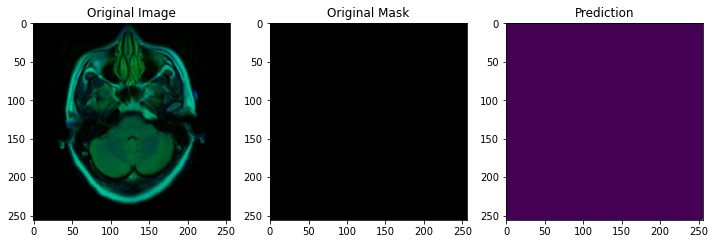

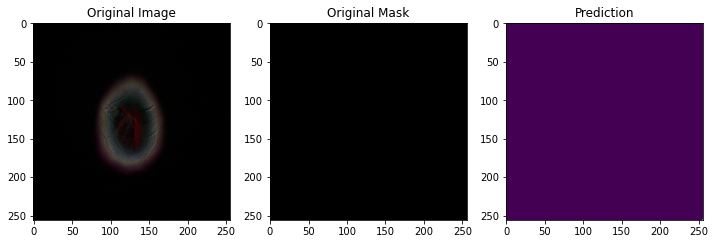

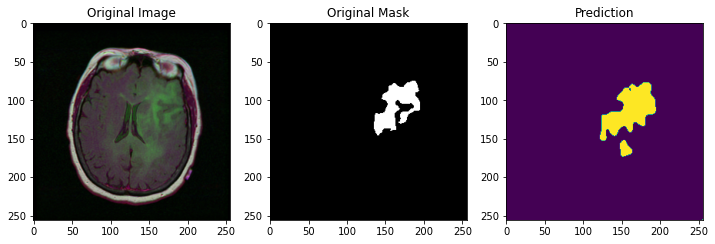

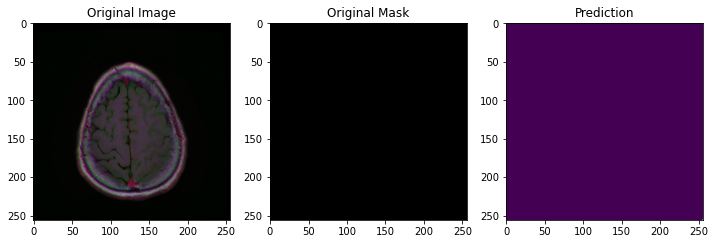

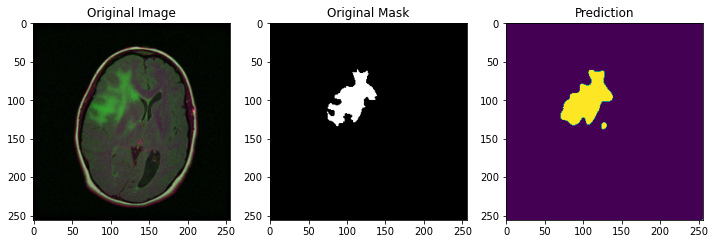

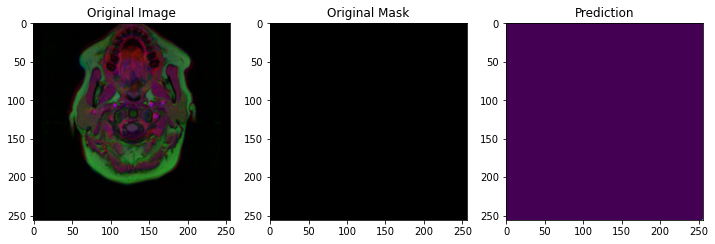

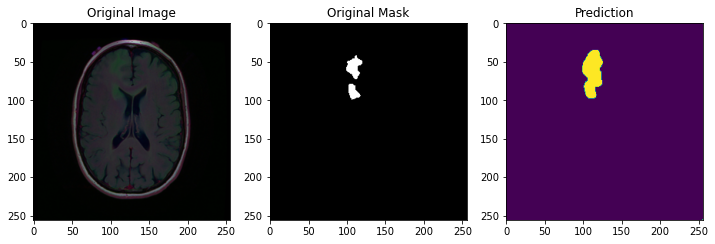

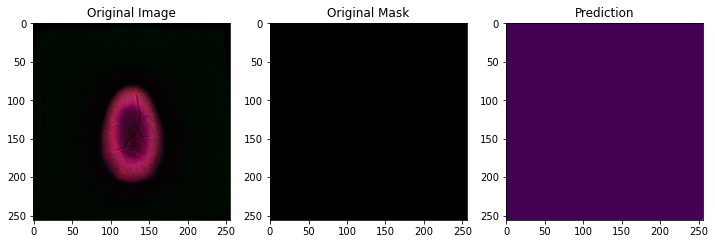

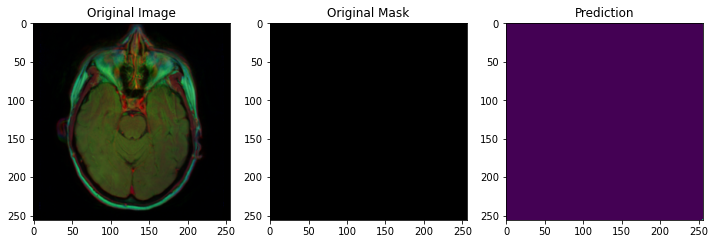

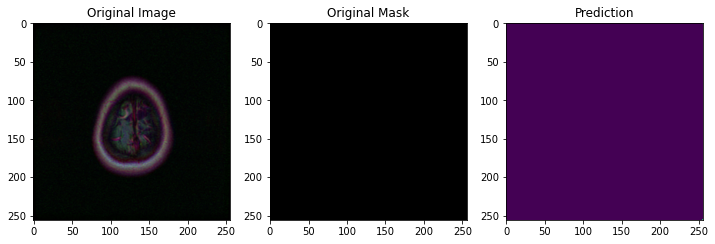

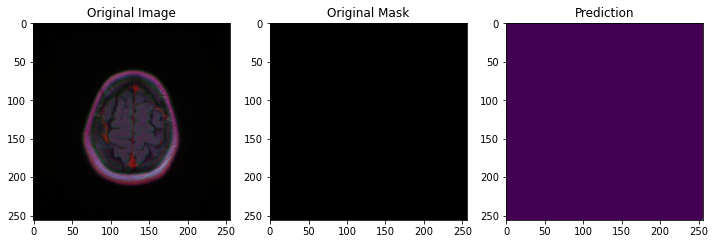

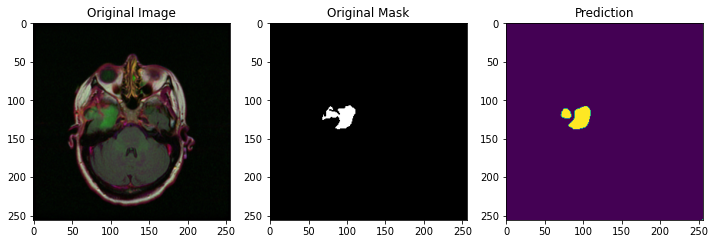

In [17]:
for i in range(20):
    index = np.random.randint(1, len(df_test.index))
    img = cv2.imread(df_test['filename'].iloc[index])
    img = cv2.resize(img ,(256, 256))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred = unet.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()